<a href="https://colab.research.google.com/github/Jay99Sohn/GEOexosome/blob/main/GEOexosome.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Cell 0: Environment Setup (imports, seed fixing, save path)

import os
import sys
import random
import numpy as np
import pandas as pd

# Reproducibility: fix random seeds
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

# Base save path for results
if "google.colab" in sys.modules:
    from google.colab import drive
    print("\n[INFO] Google Colab detected. Mounting Google Drive...")
    drive.mount("/content/drive")
    base_save_path = "/content/drive/MyDrive/geoexosome_results"
    print(f"[INFO] Drive mounted. Saving results to: {base_save_path}")
else:
    base_save_path = "./geoexosome_results"
    print(f"\n[INFO] Local environment detected. Saving results to: {base_save_path}")

os.makedirs(base_save_path, exist_ok=True)

print("=" * 60)
print("Environment setup complete!")
print(f"Results will be stored in: {base_save_path}")
print("=" * 60)



[INFO] Google Colab detected. Mounting Google Drive...
Mounted at /content/drive
[INFO] Drive mounted. Saving results to: /content/drive/MyDrive/geoexosome_results
Environment setup complete!
Results will be stored in: /content/drive/MyDrive/geoexosome_results


In [ ]:
# Cell 1: Library installation (optional) and imports

# If running on Colab for the first time, uncomment the line below:
!pip install GEOparse imbalanced-learn shap seaborn matplotlib

import os
import sys
import random
import numpy as np
import pandas as pd

import GEOparse

from sklearn.model_selection import (
    StratifiedKFold,
    GridSearchCV,
)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    accuracy_score
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import matplotlib.pyplot as plt
import seaborn as sns
import shap

sns.set(style="whitegrid", font_scale=1.2)

print("\n[INFO] All libraries successfully imported.")



[INFO] All libraries successfully imported.


In [ ]:
# Cell 2: Load GEO dataset (GSE39833) and build raw expression matrix + probe→miRNA mapping

gse_id = "GSE39833"
print(f"\n[INFO] Loading GEO dataset: {gse_id}")

gse = GEOparse.get_GEO(
    geo=gse_id,
    destdir="./data",
    annotate_gpl=True
)

print(f"[INFO] Number of GSM samples: {len(gse.gsms)}")
print(f"[INFO] Number of GPL platforms: {len(gse.gpls)}")

# -------------------------------------------------------------
# 1) Extract expression matrix and sample labels
# -------------------------------------------------------------
samples = []
expression_rows = []
labels = []

for gsm_name, gsm in gse.gsms.items():

    tbl = gsm.table
    if "VALUE" not in tbl.columns:
        print(f"[WARNING] {gsm_name} missing VALUE column. Skipped.")
        continue

    expr_vals = tbl["VALUE"].astype(float).values
    expression_rows.append(expr_vals)
    samples.append(gsm_name)

    # A) PRIMARY LABELING: Use Sample Title (most reliable)
    title_list = gsm.metadata.get("title", [""])
    title = title_list[0].lower()

    if title.startswith("hc_"):        # Healthy controls
        label_value = 0
    elif title.startswith("crc"):      # CRC patients (CRC1, CRC2, CRC3a, CRC3b, CRC4)
        label_value = 1
    else:
        label_value = None  # Unknown — fallback to metadata parsing

    # B) FALLBACK: Use metadata characteristics (TNM stage, cancer keywords)
    if label_value is None:
        characteristics = gsm.metadata.get("characteristics_ch1", []) + \
                          gsm.metadata.get("characteristics_ch2", [])
        chars_low = [c.lower() for c in characteristics]

        # Cancer indicators
        if any(("tnm" in c or "stage" in c or "cancer" in c or "adenocarcinoma" in c) for c in chars_low):
            label_value = 1
        # Healthy indicators
        elif any(("healthy" in c or "control" in c or "normal" in c) for c in chars_low):
            label_value = 0
        else:
            raise ValueError(
                f"[ERROR] Could not determine label for {gsm_name}. "
                f"Title: {title_list}, Metadata: {characteristics}"
            )

    labels.append(label_value)

expression_data = np.vstack(expression_rows)

# -------------------------------------------------------------
# 2) Build df_expression DataFrame (raw expression, probe-level)
# -------------------------------------------------------------
first_gsm = gse.gsms[samples[0]]
probe_ids = first_gsm.table["ID_REF"].tolist()

df_expression = pd.DataFrame(
    expression_data,
    columns=probe_ids,
    index=samples
)
df_expression["label"] = labels

print("\n[INFO] df_expression overview:")
print("Shape:", df_expression.shape)
print("Label distribution:\n", df_expression["label"].value_counts())

# -------------------------------------------------------------
# 3) Probe → miRNA mapping using GPL
# -------------------------------------------------------------
print("\n[INFO] Loading platform (GPL) annotation for probe → miRNA mapping...")

gpl = list(gse.gpls.values())[0]
gpl_table = gpl.table

if "ID" not in gpl_table.columns:
    raise KeyError("[ERROR] GPL table missing 'ID' column.")

# Look for a column containing miRNA names
mirna_cols = [c for c in gpl_table.columns if "mir" in c.lower()]

if len(mirna_cols) == 0:
    print("[WARNING] No miRNA column detected in GPL. Mapping skipped.")
    mapping_df = None
else:
    mirna_col = mirna_cols[0]
    print(f"[INFO] Using miRNA annotation column: {mirna_col}")

    probe_to_mirna = dict(zip(gpl_table["ID"], gpl_table[mirna_col]))
    mirna_names = [probe_to_mirna.get(pid, np.nan) for pid in probe_ids]

    mapping_df = pd.DataFrame({
        "ProbeID": probe_ids,
        "miRNA": mirna_names
    })

    mapping_path = os.path.join(base_save_path, "probe_to_miRNA_mapping.csv")
    mapping_df.to_csv(mapping_path, index=False)
    print(f"[INFO] Probe → miRNA mapping saved to: {mapping_path}")

print("\n[INFO] GSE39833 preprocessing complete (raw, probe-level).")


17-Dec-2025 22:38:10 INFO GEOparse - Downloading ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE39nnn/GSE39833/soft/GSE39833_family.soft.gz to ./data/GSE39833_family.soft.gz
INFO:GEOparse:Downloading ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE39nnn/GSE39833/soft/GSE39833_family.soft.gz to ./data/GSE39833_family.soft.gz



[INFO] Loading GEO dataset: GSE39833


100%|██████████| 11.4M/11.4M [00:00<00:00, 14.1MB/s]
17-Dec-2025 22:38:12 DEBUG downloader - Size validation passed
DEBUG:GEOparse:Size validation passed
17-Dec-2025 22:38:12 DEBUG downloader - Moving /tmp/tmpzvhetmw3 to /content/data/GSE39833_family.soft.gz
DEBUG:GEOparse:Moving /tmp/tmpzvhetmw3 to /content/data/GSE39833_family.soft.gz
17-Dec-2025 22:38:12 DEBUG downloader - Successfully downloaded ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE39nnn/GSE39833/soft/GSE39833_family.soft.gz
DEBUG:GEOparse:Successfully downloaded ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE39nnn/GSE39833/soft/GSE39833_family.soft.gz
17-Dec-2025 22:38:12 INFO GEOparse - Parsing ./data/GSE39833_family.soft.gz: 
INFO:GEOparse:Parsing ./data/GSE39833_family.soft.gz: 
17-Dec-2025 22:38:12 DEBUG GEOparse - DATABASE: GeoMiame
DEBUG:GEOparse:DATABASE: GeoMiame
17-Dec-2025 22:38:12 DEBUG GEOparse - SERIES: GSE39833
DEBUG:GEOparse:SERIES: GSE39833
17-Dec-2025 22:38:12 DEBUG GEOparse - PLATFORM: GPL14767
DEBUG:GEOparse:PLATF

[INFO] Number of GSM samples: 99
[INFO] Number of GPL platforms: 1

[INFO] df_expression overview:
Shape: (99, 15740)
Label distribution:
 label
1    88
0    11
Name: count, dtype: int64

[INFO] Loading platform (GPL) annotation for probe → miRNA mapping...
[INFO] Using miRNA annotation column: miRNA_ID
[INFO] Probe → miRNA mapping saved to: /content/drive/MyDrive/geoexosome_results/probe_to_miRNA_mapping.csv

[INFO] GSE39833 preprocessing complete (raw, probe-level).



Expression normalization, QC, feature selection, and miRNA-level aggregation
[INFO] Applying log2(x + 1) transform to expression values.


/usr/local/lib/python3.12/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log2
  result = func(self.values, **kwargs)


[INFO] Applying quantile normalization across samples (NaN-safe)...
[INFO] Normalized expression shape: (99, 15739)

3-Stage Feature Selection: Biological Filter → 2-of-3 Consensus → Final

[INFO] Dataset statistics:
  Total samples: 99
  Control samples: 11
  Cancer samples: 88
  Total probes: 15739

────────────────────────────────────────────────────────────────────────────────
[Stage 1] Biological Filtering: Fold Change + Statistical Significance
────────────────────────────────────────────────────────────────────────────────

[Stage 1 Results]
  Probes with |log2FC| > 0.585 (1.5x): 3307
  Probes with P < 0.05: 2031
  Probes passing both criteria: 1745

────────────────────────────────────────────────────────────────────────────────
[Stage 2] Multi-method Selection: LASSO + SVM-RFE + RF (2-of-3 Consensus)
────────────────────────────────────────────────────────────────────────────────

[Method A] LASSO Regularization (L1 penalty)...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


  LASSO selected: 73 features (alpha=0.009471)

[Method B] SVM-RFE (Recursive Feature Elimination)...
  Running RFE (target: 150 features)...
  SVM-RFE selected: 150 features

[Method C] Random Forest Feature Importance...
  RF selected: 262 features (top 15% by importance)

[Computing 2-of-3 consensus voting...]
  Features selected by ≥2 methods: 107

  Voting distribution:
    Selected by 3/3 methods: 22 features
    Selected by 2/3 methods: 85 features
    Selected by 1/3 methods: 249 features

  Final consensus: 107 features

────────────────────────────────────────────────────────────────────────────────
[Stage 3] Final Feature Selection
────────────────────────────────────────────────────────────────────────────────

[Feature Selection Summary]
  Stage 1 (Biological Filter): 1745 features
  Stage 2 (2-of-3 Consensus): 107 features
  Stage 3 (Final): 107 features

[INFO] Applying z-score normalization to selected features...


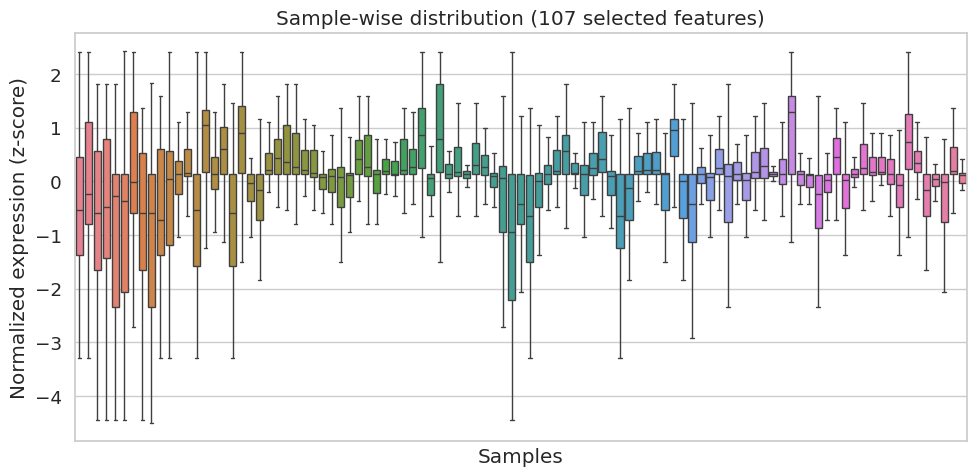

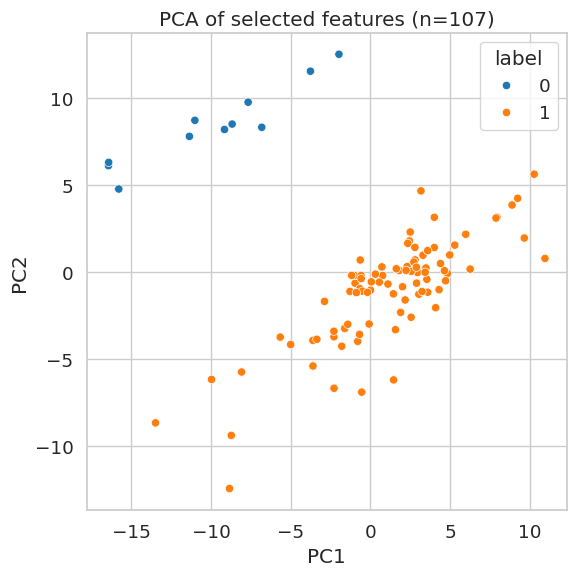


[INFO] X shape after feature selection: (99, 107)
[INFO] Label distribution: [11 88]

[Saving feature selection results...]
[INFO] Feature selection results saved to: /content/drive/MyDrive/geoexosome_results/feature_selection_results.csv

Top 10 features (by consensus and p-value):
 Probe_ID  Fold_Change  Log2_FC      P_Value  N_Methods_Selected
    14525     5.220788 2.384268 6.648803e-07                   3
    11859     5.340569 2.416994 7.894863e-07                   3
     3294     6.140221 2.618291 9.907192e-07                   3
      425     5.023402 2.328665 1.241628e-06                   3
     1869     4.951862 2.307971 1.241628e-06                   3
     5464     5.170610 2.370335 1.241628e-06                   3
     9926     4.945675 2.306168 3.724439e-06                   3
     7303     4.768178 2.253438 4.145972e-06                   3
      713     4.882219 2.287537 4.367571e-06                   3
    11718     3.751301 1.907391 3.046565e-05                   3


In [7]:
# Cell 3: Normalization + QC + 3-Stage Feature Selection (2-of-3) + miRNA aggregation
# FINAL VERSION: Complete 2-of-3 consensus with LASSO + SVM-RFE + RF

from sklearn.decomposition import PCA
from scipy.stats import mannwhitneyu
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from collections import Counter

print("\n" + "=" * 80)
print("Expression normalization, QC, feature selection, and miRNA-level aggregation")
print("=" * 80)

# ================================================================
# 1. Split expression and labels
# ================================================================
expr_raw = df_expression.drop(columns=["label"]).copy()
labels = df_expression["label"].astype(int).values
sample_ids = df_expression.index.tolist()

# Ensure numeric
expr_raw = expr_raw.apply(pd.to_numeric, errors="coerce")

# Drop probes with all NaN
expr_raw = expr_raw.dropna(axis=1, how="all")

# Replace remaining NaNs with probe-wise median
expr_raw = expr_raw.fillna(expr_raw.median(axis=0))

# ================================================================
# 2. Log2 transform (safe) + quantile normalization
# ================================================================
if expr_raw.values.max() > 20:
    print("[INFO] Applying log2(x + 1) transform to expression values.")
    expr_log = np.log2(expr_raw + 1.0)
else:
    print("[INFO] Values appear already log-transformed. Skipping log2.")
    expr_log = expr_raw.copy()

# Replace inf, -inf after log2
expr_log = expr_log.replace([np.inf, -np.inf], np.nan)
expr_log = expr_log.fillna(expr_log.median(axis=0))


# Quantile Normalization (NaN-safe version)
def quantile_normalize(df: pd.DataFrame) -> pd.DataFrame:
    """
    Quantile normalization (NaN-safe).
    """
    df = df.copy()
    df = df.astype(float)
    ranks = df.rank(axis=0, method="average", na_option="bottom")
    sorted_vals = np.sort(df.values, axis=0)
    mean_sorted = np.nanmean(sorted_vals, axis=1)
    qn = df.copy()
    for col in df.columns:
        qn[col] = ranks[col].apply(lambda r: mean_sorted[int(r) - 1])
    return qn


print("[INFO] Applying quantile normalization across samples (NaN-safe)...")
expr_qn = quantile_normalize(expr_log)

print(f"[INFO] Normalized expression shape: {expr_qn.shape}")

# ================================================================
# 3. Three-Stage Feature Selection (BEFORE z-score!)
# ================================================================
print("\n" + "=" * 80)
print("3-Stage Feature Selection: Biological Filter → 2-of-3 Consensus → Final")
print("=" * 80)

# Use quantile-normalized data for feature selection (NOT z-scored!)
expr_df = pd.DataFrame(expr_qn.values, index=sample_ids, columns=expr_qn.columns)
label_series = pd.Series(labels, index=sample_ids)

expr_control = expr_df[label_series == 0]
expr_cancer = expr_df[label_series == 1]

print(f"\n[INFO] Dataset statistics:")
print(f"  Total samples: {len(expr_df)}")
print(f"  Control samples: {len(expr_control)}")
print(f"  Cancer samples: {len(expr_cancer)}")
print(f"  Total probes: {expr_df.shape[1]}")

# ----------------------------------------------------------------
# Stage 1: Biological Filtering (Fold Change + P-value)
# ----------------------------------------------------------------
print("\n" + "─" * 80)
print("[Stage 1] Biological Filtering: Fold Change + Statistical Significance")
print("─" * 80)

fold_changes = {}
p_values = {}
log2_fold_changes = {}
selected_bio = []

for probe in expr_df.columns:
    control_vals = expr_control[probe].values
    cancer_vals = expr_cancer[probe].values

    control_mean = control_vals.mean()
    cancer_mean = cancer_vals.mean()

    # Log2 Fold Change (data is already log2-transformed)
    log2fc = cancer_mean - control_mean
    log2_fold_changes[probe] = log2fc

    # Regular fold change for interpretation
    fc = 2 ** log2fc
    fold_changes[probe] = fc

    # Mann-Whitney U test
    try:
        _, pval = mannwhitneyu(control_vals, cancer_vals, alternative='two-sided')
        p_values[probe] = pval
    except:
        p_values[probe] = 1.0

    # Apply filters: |log2FC| > 0.585 (≈1.5x) AND p < 0.05
    if abs(log2fc) > 0.585 and pval < 0.05:
        selected_bio.append(probe)

print(f"\n[Stage 1 Results]")
print(f"  Probes with |log2FC| > 0.585 (1.5x): {sum(abs(log2_fold_changes[p]) > 0.585 for p in expr_df.columns)}")
print(f"  Probes with P < 0.05: {sum(p_values[p] < 0.05 for p in expr_df.columns)}")
print(f"  Probes passing both criteria: {len(selected_bio)}")

# If too strict, relax criteria
if len(selected_bio) < 100:
    print(f"\n[INFO] Relaxing criteria to |log2FC| > 0.5 (1.4x) AND p < 0.1...")
    selected_bio = []
    for probe in expr_df.columns:
        log2fc = log2_fold_changes[probe]
        pval = p_values[probe]
        if abs(log2fc) > 0.5 and pval < 0.1:
            selected_bio.append(probe)
    print(f"[INFO] Relaxed criteria: {len(selected_bio)} features")

# Safety backup
if len(selected_bio) < 50:
    print(f"\n[WARNING] Still only {len(selected_bio)} features.")
    print(f"[INFO] Using top 1000 by variance as safety backup.")
    probe_var = expr_df.var(axis=0)
    selected_bio = probe_var.nlargest(min(1000, len(expr_df.columns))).index.tolist()
    print(f"[INFO] Backup: {len(selected_bio)} features")

# ----------------------------------------------------------------
# Stage 2: Multi-method Selection (TRUE 2-of-3 Consensus)
# ----------------------------------------------------------------
print("\n" + "─" * 80)
print("[Stage 2] Multi-method Selection: LASSO + SVM-RFE + RF (2-of-3 Consensus)")
print("─" * 80)

X_bio = expr_df[selected_bio].values
y_arr = label_series.values

# Standardize once for methods that need it
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_bio)

# ────────────────────────────────────────────────────────────────
# Method A: LASSO Regularization
# ────────────────────────────────────────────────────────────────
print("\n[Method A] LASSO Regularization (L1 penalty)...")
try:
    lasso = LassoCV(
        cv=5,
        random_state=SEED,
        max_iter=20000,
        n_jobs=-1,
        tol=1e-3
    )
    lasso.fit(X_scaled, y_arr)

    lasso_feat = [selected_bio[i] for i, c in enumerate(lasso.coef_) if c != 0]
    print(f"  LASSO selected: {len(lasso_feat)} features (alpha={lasso.alpha_:.6f})")

    # If LASSO selects nothing, use top by coefficient magnitude
    if len(lasso_feat) == 0:
        print(f"  [WARNING] LASSO selected 0 features, using top 200 by |coefficient|")
        lasso_coef_abs = np.abs(lasso.coef_)
        top_idx = np.argsort(lasso_coef_abs)[-200:]
        lasso_feat = [selected_bio[i] for i in top_idx]
        print(f"  Adjusted: {len(lasso_feat)} features")

except Exception as e:
    print(f"  [ERROR] LASSO failed: {e}")
    var_bio = expr_df[selected_bio].var(axis=0)
    lasso_feat = var_bio.nlargest(min(200, len(selected_bio))).index.tolist()
    print(f"  Fallback: top {len(lasso_feat)} by variance")

# ────────────────────────────────────────────────────────────────
# Method B: SVM-RFE (Recursive Feature Elimination)
# ────────────────────────────────────────────────────────────────
print("\n[Method B] SVM-RFE (Recursive Feature Elimination)...")
try:
    # Target: select reasonable number of features
    n_features_target = min(150, len(selected_bio) // 3)

    svc = SVC(kernel='linear', class_weight='balanced', random_state=SEED)
    rfe = RFE(
        estimator=svc,
        n_features_to_select=n_features_target,
        step=10,
        verbose=0
    )

    print(f"  Running RFE (target: {n_features_target} features)...")
    rfe.fit(X_scaled, y_arr)

    svm_rfe_feat = [selected_bio[i] for i in np.where(rfe.support_)[0]]
    print(f"  SVM-RFE selected: {len(svm_rfe_feat)} features")

except Exception as e:
    print(f"  [ERROR] SVM-RFE failed: {e}")
    var_bio = expr_df[selected_bio].var(axis=0)
    svm_rfe_feat = var_bio.nlargest(min(150, len(selected_bio))).index.tolist()
    print(f"  Fallback: top {len(svm_rfe_feat)} by variance")

# ────────────────────────────────────────────────────────────────
# Method C: Random Forest Feature Importance
# ────────────────────────────────────────────────────────────────
print("\n[Method C] Random Forest Feature Importance...")
try:
    # Apply SMOTE for balanced training
    k_neighbors = min(3, sum(y_arr == 0) - 1)
    smote = SMOTE(random_state=SEED, k_neighbors=k_neighbors)
    X_smoted, y_smoted = smote.fit_resample(X_bio, y_arr)

    rf = RandomForestClassifier(
        n_estimators=500,
        random_state=SEED,
        n_jobs=-1,
        max_depth=10,
        class_weight='balanced_subsample'
    )
    rf.fit(X_smoted, y_smoted)

    # Select top 15% by importance
    threshold = np.percentile(rf.feature_importances_, 85)
    rf_feat = [selected_bio[i] for i, imp in enumerate(rf.feature_importances_) if imp > threshold]
    print(f"  RF selected: {len(rf_feat)} features (top 15% by importance)")

except Exception as e:
    print(f"  [ERROR] RF failed: {e}")
    var_bio = expr_df[selected_bio].var(axis=0)
    rf_feat = var_bio.nlargest(min(120, len(selected_bio))).index.tolist()
    print(f"  Fallback: top {len(rf_feat)} by variance")

# ────────────────────────────────────────────────────────────────
# 2-of-3 Consensus Voting
# ────────────────────────────────────────────────────────────────
print("\n[Computing 2-of-3 consensus voting...]")
all_feat = list(lasso_feat) + list(svm_rfe_feat) + list(rf_feat)
feat_counts = Counter(all_feat)

# Features selected by >= 2 methods
consensus_strict = [f for f, cnt in feat_counts.items() if cnt >= 2]
print(f"  Features selected by ≥2 methods: {len(consensus_strict)}")

# Show detailed voting distribution
print("\n  Voting distribution:")
for n_votes in [3, 2, 1]:
    n_features = sum(1 for cnt in feat_counts.values() if cnt == n_votes)
    print(f"    Selected by {n_votes}/3 methods: {n_features} features")

# Safety check
if len(consensus_strict) < 30:
    print(f"\n  [WARNING] Strict 2-of-3 consensus too small ({len(consensus_strict)})")
    print(f"  [INFO] Using 1-of-3 (union) to ensure sufficient features")
    consensus = [f for f, cnt in feat_counts.items() if cnt >= 1]
else:
    consensus = consensus_strict

print(f"\n  Final consensus: {len(consensus)} features")

# ----------------------------------------------------------------
# Stage 3: Final Feature Set
# ----------------------------------------------------------------
print("\n" + "─" * 80)
print("[Stage 3] Final Feature Selection")
print("─" * 80)

# Limit to 1000 if needed
if len(consensus) > 1000:
    print(f"[INFO] Limiting to top 1000 by variance")
    var_cons = expr_df[consensus].var(axis=0)
    final_feat = var_cons.nlargest(1000).index.tolist()
else:
    final_feat = consensus

print(f"\n[Feature Selection Summary]")
print(f"  Stage 1 (Biological Filter): {len(selected_bio)} features")
print(f"  Stage 2 (2-of-3 Consensus): {len(consensus)} features")
print(f"  Stage 3 (Final): {len(final_feat)} features")

# ================================================================
# 4. Z-score normalization (AFTER feature selection, only selected features)
# ================================================================
print("\n[INFO] Applying z-score normalization to selected features...")
expr_selected = expr_df[final_feat].copy()
expr_norm = (expr_selected - expr_selected.mean(axis=0)) / expr_selected.std(axis=0, ddof=0)
expr_norm = expr_norm.fillna(0.0)

# ================================================================
# 5. QC plots (on z-scored selected features)
# ================================================================
qc_dir = os.path.join(base_save_path, "qc")
os.makedirs(qc_dir, exist_ok=True)

plt.figure(figsize=(10, 5))
sns.boxplot(data=expr_norm.T, whis=1.5, showfliers=False)
plt.xlabel("Samples")
plt.ylabel("Normalized expression (z-score)")
plt.title(f"Sample-wise distribution ({len(final_feat)} selected features)")
plt.xticks([], [])
plt.tight_layout()
plt.savefig(os.path.join(qc_dir, "sample_boxplot_selected_features.png"), dpi=300)
plt.show()

pca = PCA(n_components=2, random_state=SEED)
X_pca = pca.fit_transform(expr_norm.values)
df_pca = pd.DataFrame({
    "PC1": X_pca[:, 0],
    "PC2": X_pca[:, 1],
    "label": labels
}, index=sample_ids)

plt.figure(figsize=(6, 6))
sns.scatterplot(data=df_pca, x="PC1", y="PC2", hue="label",
                palette={0: "tab:blue", 1: "tab:orange"})
plt.title(f"PCA of selected features (n={len(final_feat)})")
plt.tight_layout()
plt.savefig(os.path.join(qc_dir, "pca_selected_features.png"), dpi=300)
plt.show()

# ================================================================
# 6. Prepare final X and y for modeling
# ================================================================
expr_model = expr_norm.copy()
feature_cols = final_feat
X = expr_model.values
y = labels

print(f"\n[INFO] X shape after feature selection: {X.shape}")
print(f"[INFO] Label distribution: {np.bincount(y)}")

# ================================================================
# 7. Save comprehensive feature selection results
# ================================================================
print("\n[Saving feature selection results...]")

# Create detailed results DataFrame
feature_results = pd.DataFrame({
    'Probe_ID': final_feat,
    'Fold_Change': [fold_changes[f] for f in final_feat],
    'Log2_FC': [log2_fold_changes[f] for f in final_feat],
    'P_Value': [p_values[f] for f in final_feat],
    'LASSO_Selected': [1 if f in lasso_feat else 0 for f in final_feat],
    'SVM_RFE_Selected': [1 if f in svm_rfe_feat else 0 for f in final_feat],
    'RF_Selected': [1 if f in rf_feat else 0 for f in final_feat],
    'N_Methods_Selected': [feat_counts[f] if f in feat_counts else 0 for f in final_feat],
    'Variance': [expr_df[f].var() for f in final_feat]
})

# Sort by number of methods and p-value
feature_results = feature_results.sort_values(
    ['N_Methods_Selected', 'P_Value'],
    ascending=[False, True]
)

# Save to CSV
results_path = os.path.join(base_save_path, 'feature_selection_results.csv')
feature_results.to_csv(results_path, index=False)
print(f"[INFO] Feature selection results saved to: {results_path}")

# Display top 10
print("\nTop 10 features (by consensus and p-value):")
display_cols = ['Probe_ID', 'Fold_Change', 'Log2_FC', 'P_Value', 'N_Methods_Selected']
print(feature_results.head(10)[display_cols].to_string(index=False))

print("\n" + "=" * 80)

# ================================================================
# 8. miRNA-level aggregation (for descriptive use)
# ================================================================
df_miRNA_expr = None

if mapping_df is None:
    print("[WARNING] No probe→miRNA mapping found.")
else:
    print("[INFO] Aggregating miRNA-level expression...")
    mapping_valid = mapping_df.dropna(subset=["miRNA"])
    mapping_valid = mapping_valid[mapping_valid["ProbeID"].isin(feature_cols)]

    if mapping_valid.empty:
        print("[WARNING] No overlap between selected probes and miRNA mapping.")
    else:
        mirna_to_probes = mapping_valid.groupby("miRNA")["ProbeID"].apply(list)
        mirna_expr = {
            mir: expr_model[probes].mean(axis=1)
            for mir, probes in mirna_to_probes.items()
        }
        df_miRNA_expr = pd.DataFrame(mirna_expr, index=sample_ids)
        df_miRNA_expr["label"] = labels
        mirna_path = os.path.join(base_save_path, "miRNA_expression_normalized.csv")
        df_miRNA_expr.to_csv(mirna_path)
        print(f"[INFO] miRNA-level expression saved to: {mirna_path}")

print("\n" + "=" * 80)
print("[INFO] Cell 3 completed successfully!")
print("  Final feature count: {0}".format(len(final_feat)))
print("  Ready for nested CV modeling (Cell 4)")
print("=" * 80)

In [ ]:
# Cell 4
# - Outer CV (5-fold): unbiased performance estimation (n≈100)
# - Inner CV (3-fold): hyperparameter optimization
# - Compare:
#   (1) RandomForest + SMOTE(k=3)
#   (2) RandomForest (class_weight="balanced_subsample") without SMOTE
#   (3) (optional) SVM / Logistic Regression with SMOTE + scaling
# - Multiple performance metrics + bootstrap 95% CI for AUC
# - Final model training (for interpretation) clearly separated

import json
from scipy import stats  # for bootstrap CI

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    balanced_accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# ----------------------------------------------------------------
# 0. Reproducibility
# ----------------------------------------------------------------
try:
    SEED
except NameError:
    SEED = 42

np.random.seed(SEED)
random.seed(SEED)

print("\n" + "=" * 80)
print("Nested Cross-Validation (5x3) with SMOTE vs class_weight — Model Comparison")
print("=" * 80)

# ----------------------------------------------------------------
# 1. CV settings
# ----------------------------------------------------------------
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

# ----------------------------------------------------------------
# 2. Define candidate models and hyperparameter grids
# ----------------------------------------------------------------
models = {}

# 2.1 Random Forest + SMOTE (Pipeline: SMOTE → RF)
models["RandomForest_SMOTE"] = {
    "pipeline": ImbPipeline([
        ("smote", SMOTE(random_state=SEED, k_neighbors=3)),
        ("clf", RandomForestClassifier(
            random_state=SEED,
            n_jobs=-1,
            class_weight="balanced_subsample"
        ))
    ]),
    "param_grid": {
        "clf__n_estimators": [200, 500],
        "clf__max_depth": [None, 5, 10],
        "clf__max_features": [0.3, 0.5, "sqrt"]
    }
}

# 2.2 Random Forest (class_weight only, no SMOTE)
models["RandomForest_Weighted"] = {
    "pipeline": ImbPipeline([
        ("clf", RandomForestClassifier(
            random_state=SEED,
            n_jobs=-1,
            class_weight="balanced_subsample"
        ))
    ]),
    "param_grid": {
        "clf__n_estimators": [200, 500],
        "clf__max_depth": [None, 5, 10],
        "clf__max_features": [0.3, 0.5, "sqrt"]
    }
}

# 2.3 SVM with RBF kernel (optional)
models["SVM"] = {
    "pipeline": ImbPipeline([
        ("smote", SMOTE(random_state=SEED, k_neighbors=3)),
        ("scaler", StandardScaler()),
        ("clf", SVC(
            probability=True,
            random_state=SEED,
            class_weight="balanced"
        ))
    ]),
    "param_grid": {
        "clf__C": [0.1, 1, 10],
        "clf__gamma": ["scale", "auto"]
    }
}

# 2.4 Logistic Regression (optional)
models["LogisticRegression"] = {
    "pipeline": ImbPipeline([
        ("smote", SMOTE(random_state=SEED, k_neighbors=3)),
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(
            max_iter=500,
            random_state=SEED,
            class_weight="balanced"
        ))
    ]),
    "param_grid": {
        "clf__C": [0.1, 1, 10],
        "clf__penalty": ["l2"],
        "clf__solver": ["lbfgs"]
    }
}

# ----------------------------------------------------------------
# 3. Utility: Bootstrap 95% CI for ROC-AUC
# ----------------------------------------------------------------
def bootstrap_auc_ci(y_true, y_proba, n_bootstrap=1000, alpha=0.05, random_state=SEED):
    """
    Compute bootstrap confidence interval for ROC-AUC.
    """
    rng = np.random.RandomState(random_state)
    y_true = np.asarray(y_true)
    y_proba = np.asarray(y_proba)
    n = len(y_true)

    aucs = []
    for _ in range(n_bootstrap):
        indices = rng.choice(n, n, replace=True)
        if len(np.unique(y_true[indices])) < 2:
            # Skip bootstrap samples with only one class
            continue
        aucs.append(roc_auc_score(y_true[indices], y_proba[indices]))

    if len(aucs) == 0:
        return np.nan, np.nan

    lower = np.percentile(aucs, 100 * (alpha / 2))
    upper = np.percentile(aucs, 100 * (1 - alpha / 2))
    return float(lower), float(upper)

# ----------------------------------------------------------------
# 4. Nested CV loop: out-of-fold predictions + rich metrics
# ----------------------------------------------------------------
results = {}
oof_predictions = {}

for name, cfg in models.items():
    print("\n" + "-" * 60)
    print(f"Model: {name}")
    print("-" * 60)

    oof_proba = np.zeros_like(y, dtype=float)
    oof_pred = np.zeros_like(y, dtype=int)

    train_auc_folds = []
    test_auc_folds = []

    # --- Outer CV loop ---
    for fold_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), start=1):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Class distribution in each fold
        train_pos = int(y_train.sum())
        test_pos = int(y_test.sum())
        print(f"  Fold {fold_idx} class distribution:")
        print(f"    Train: {train_pos}/{len(y_train)} ({train_pos/len(y_train):.2%}) positive")
        print(f"    Test : {test_pos}/{len(y_test)} ({test_pos/len(y_test):.2%}) positive")

        gs = GridSearchCV(
            estimator=cfg["pipeline"],
            param_grid=cfg["param_grid"],
            scoring="roc_auc",
            cv=inner_cv,
            n_jobs=-1,
            refit=True
        )
        gs.fit(X_train, y_train)

        # Train AUC on this outer train set
        train_proba = gs.predict_proba(X_train)[:, 1]
        train_auc = roc_auc_score(y_train, train_proba)
        train_auc_folds.append(train_auc)

        # Predict on held-out outer test fold
        proba = gs.predict_proba(X_test)[:, 1]
        pred = (proba >= 0.5).astype(int)

        test_auc = roc_auc_score(y_test, proba)
        test_auc_folds.append(test_auc)

        oof_proba[test_idx] = proba
        oof_pred[test_idx] = pred

        print(f"    Fold {fold_idx}: best inner-CV AUC = {gs.best_score_:.4f}")
        print(f"    Fold {fold_idx}: train AUC (outer)   = {train_auc:.4f}")
        print(f"    Fold {fold_idx}: test  AUC (outer)   = {test_auc:.4f}")

    # Aggregate performance over outer folds (OOF)
    cm = confusion_matrix(y, oof_pred)
    auc = roc_auc_score(y, oof_proba)
    acc = accuracy_score(y, oof_pred)
    bal_acc = balanced_accuracy_score(y, oof_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y, oof_pred, average="binary", zero_division=0
    )

    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    sensitivity = recall  # same as recall for positive class

    # Bootstrap CI for AUC
    ci_lower, ci_upper = bootstrap_auc_ci(y, oof_proba, n_bootstrap=1000, alpha=0.05)

    train_auc_mean = float(np.mean(train_auc_folds))
    test_auc_mean = float(np.mean(test_auc_folds))

    print("\n  Out-of-fold performance (aggregated over 5 outer folds):")
    print(f"    ROC-AUC           : {auc:.4f}")
    print(f"    95% CI (bootstrap): [{ci_lower:.4f}, {ci_upper:.4f}]")
    print(f"    Accuracy          : {acc:.4f}")
    print(f"    Balanced Accuracy : {bal_acc:.4f}")
    print(f"    Precision         : {precision:.4f}")
    print(f"    Recall (Sensitivity): {sensitivity:.4f}")
    print(f"    Specificity       : {specificity:.4f}")
    print(f"    F1-score          : {f1:.4f}")
    print(f"    Mean Train AUC (outer folds): {train_auc_mean:.4f}")
    print(f"    Mean Test  AUC (outer folds): {test_auc_mean:.4f}")
    print("    Confusion matrix:")
    print(cm)

    results[name] = {
        "oof_auc": float(auc),
        "oof_auc_ci": [ci_lower, ci_upper],
        "oof_accuracy": float(acc),
        "oof_balanced_accuracy": float(bal_acc),
        "precision": float(precision),
        "recall_sensitivity": float(sensitivity),
        "specificity": float(specificity),
        "f1_score": float(f1),
        "confusion_matrix": cm.tolist(),
        "param_grid": cfg["param_grid"],
        "train_auc_mean": train_auc_mean,
        "test_auc_mean": test_auc_mean,
        "best_params": gs.best_params_,
        "best_estimator": gs.best_estimator_
    }

    oof_predictions[name] = {
        "y_true": y.copy(),
        "y_proba": oof_proba,
        "y_pred": oof_pred
    }

# ----------------------------------------------------------------
# 5. Select best model based on OOF ROC-AUC
# ----------------------------------------------------------------
best_name = max(results, key=lambda k: results[k]["oof_auc"])

print("\n" + "=" * 80)
print("Model selection summary (based on nested OOF ROC-AUC):")
for m_name, res in results.items():
    print(f"  {m_name}: OOF AUC = {res['oof_auc']:.4f} "
          f"(95% CI [{res['oof_auc_ci'][0]:.4f}, {res['oof_auc_ci'][1]:.4f}])")
print("=" * 80)

print(f"Best model selected: {best_name}")
print(f"OOF ROC-AUC (best): {results[best_name]['oof_auc']:.4f}")
print(f"OOF Accuracy      : {results[best_name]['oof_accuracy']:.4f}")
print(f"OOF Balanced Acc  : {results[best_name]['oof_balanced_accuracy']:.4f}")
print("=" * 80)

# ----------------------------------------------------------------
# 6. Final model training on full dataset (for interpretation only)
# ----------------------------------------------------------------
print("\n" + "=" * 80)
print("Final model training on full dataset (for interpretation only)")
print("Note: Performance must be interpreted from nested OOF metrics above.")
print("=" * 80)

best_cfg = models[best_name]

final_model = GridSearchCV(
    estimator=best_cfg["pipeline"],
    param_grid=best_cfg["param_grid"],
    scoring="roc_auc",
    cv=inner_cv,
    n_jobs=-1,
    refit=True
)
final_model.fit(X, y)

best_full_model = final_model.best_estimator_
best_full_params = final_model.best_params_

print(f"Final model (refit on full dataset): {best_name}")
print("Best hyperparameters (inner CV on full data):")
print(best_full_params)

# JSON-safe results (remove non-serializable objects)
results_json_safe = {}
for m_name, res in results.items():
    res_copy = {k: v for k, v in res.items() if k not in ["best_estimator"]}
    results_json_safe[m_name] = res_copy

metrics_json_path = os.path.join(base_save_path, "nested_cv_model_selection_results.json")
with open(metrics_json_path, "w", encoding="utf-8") as f:
    json.dump(
        {
            "results": results_json_safe,
            "best_model_name": best_name,
            "best_model_params": best_full_params
        },
        f,
        indent=2,
        ensure_ascii=False
    )

print(f"[INFO] Nested CV model selection summary saved to: {metrics_json_path}")


In [ ]:
# Cell 5:
# ROC curve and confusion matrix visualization for the selected model
# using the nested OOF predictions stored in Cell 4.

print("\n" + "=" * 70)
print(f"Out-of-fold performance summary for: {best_name}")
print("=" * 70)

y_true_best = oof_predictions[best_name]["y_true"]
y_proba_best = oof_predictions[best_name]["y_proba"]
y_pred_best = oof_predictions[best_name]["y_pred"]

auc_best = roc_auc_score(y_true_best, y_proba_best)
acc_best = accuracy_score(y_true_best, y_pred_best)
cm_best = confusion_matrix(y_true_best, y_pred_best)

print(f"OOF ROC-AUC: {auc_best:.4f}")
print(f"OOF Accuracy: {acc_best:.4f}")
print("Confusion matrix:")
print(cm_best)

# ROC curve
fpr, tpr, _ = roc_curve(y_true_best, y_proba_best)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_best:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve (Nested OOF, {best_name})")
plt.legend(loc="lower right")
plt.tight_layout()

roc_path = os.path.join(base_save_path, f"roc_curve_{best_name}_nested.png")
plt.savefig(roc_path, dpi=300)
plt.show()
print(f"[INFO] ROC curve saved to: {roc_path}")

# Confusion matrix heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(cm_best, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title(f"Confusion Matrix (Nested OOF, {best_name})")
plt.tight_layout()

cm_path = os.path.join(base_save_path, f"confusion_matrix_{best_name}_nested.png")
plt.savefig(cm_path, dpi=300)
plt.show()
print(f"[INFO] Confusion matrix saved to: {cm_path}")


In [ ]:
# Cell 6:
# Compute optimal classification threshold using Youden’s J statistic
# and recalculate performance metrics with this optimal threshold.

print("\n" + "=" * 70)
print("Optimal threshold calculation using Youden’s J statistic")
print("=" * 70)

from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score, balanced_accuracy_score, precision_recall_fscore_support

# Use OOF predictions from Cell 5
y_true = y_true_best
y_proba = y_proba_best

# 1) Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_proba)

# 2) Compute Youden’s J for all thresholds
youden_j = tpr - fpr

# 3) Find optimal threshold (maximize Youden's J)
j_best_idx = np.argmax(youden_j)
optimal_threshold = thresholds[j_best_idx]

print(f"[INFO] Optimal threshold (Youden’s J): {optimal_threshold:.4f}")

# 4) Recalculate predictions based on the optimal threshold
y_pred_opt = (y_proba >= optimal_threshold).astype(int)

# 5) Compute new metrics
cm_opt = confusion_matrix(y_true, y_pred_opt)
acc_opt = accuracy_score(y_true, y_pred_opt)
bal_acc_opt = balanced_accuracy_score(y_true, y_pred_opt)
prec_opt, rec_opt, f1_opt, _ = precision_recall_fscore_support(
    y_true, y_pred_opt, average="binary", zero_division=0
)

tn, fp, fn, tp = cm_opt.ravel()
spec_opt = tn / (tn + fp) if (tn + fp) > 0 else 0.0

print("\nUpdated performance with optimal threshold:")
print(f"  Accuracy          : {acc_opt:.4f}")
print(f"  Balanced Accuracy : {bal_acc_opt:.4f}")
print(f"  Precision         : {prec_opt:.4f}")
print(f"  Recall (Sensitivity): {rec_opt:.4f}")
print(f"  Specificity       : {spec_opt:.4f}")
print(f"  F1-score          : {f1_opt:.4f}")
print("  Confusion matrix:")
print(cm_opt)

# Save threshold-adjusted performance
thresh_save_path = os.path.join(base_save_path, "optimal_threshold_performance.json")
with open(thresh_save_path, "w", encoding="utf-8") as f:
    json.dump(
        {
            "optimal_threshold": float(optimal_threshold),
            "accuracy": float(acc_opt),
            "balanced_accuracy": float(bal_acc_opt),
            "precision": float(prec_opt),
            "recall_sensitivity": float(rec_opt),
            "specificity": float(spec_opt),
            "f1_score": float(f1_opt),
            "confusion_matrix": cm_opt.tolist()
        },
        f,
        indent=2,
        ensure_ascii=False
    )

print(f"[INFO] Threshold-adjusted metrics saved to: {thresh_save_path}")
print("=" * 70)


In [ ]:
# ================================================================
# Random Forest – feature importance and SHAP analysis
# ================================================================

import os

# Ensure result directory exists
RESULT_DIR = "/content/drive/MyDrive/geoexosome_results"
os.makedirs(RESULT_DIR, exist_ok=True)

print("\n======================================================================")
print("Random Forest – feature importance and SHAP analysis")
print("======================================================================")

# 1) Select best RF model
best_model_name = "RandomForest_SMOTE" if "RandomForest_SMOTE" in results else list(results.keys())[0]
rf_clf = results[best_model_name]["best_estimator"].named_steps["clf"]
print(f"[INFO] Using RandomForest model for SHAP: {best_model_name}")

# 2) Compute RF feature importances
rf_importances = rf_clf.feature_importances_
rf_df = pd.DataFrame({"ProbeID": feature_cols, "RF_Importance": rf_importances})
rf_df.to_csv(f"{RESULT_DIR}/rf_feature_importance_probes.csv", index=False)
print(f"[INFO] RF feature importance saved to: {RESULT_DIR}/rf_feature_importance_probes.csv")

# 3) SHAP values
print("\n[INFO] Computing SHAP values for Random Forest (TreeExplainer)...")

explainer = shap.TreeExplainer(rf_clf)
shap_values = explainer.shap_values(X)

if isinstance(shap_values, list):
    shap_class1 = shap_values[1]  # class 1 (CRC)
else:
    shap_class1 = shap_values

# Fix SHAP dimensionality
shap_arr_vis = shap_class1
while shap_arr_vis.ndim > 2:
    shap_arr_vis = shap_arr_vis.mean(axis=-1)

# Compute SHAP importance vector
shap_importance_vector = np.abs(shap_arr_vis).mean(axis=0)
print(f"[INFO] SHAP importance vector shape: {shap_importance_vector.shape}")

# Save SHAP importance
shap_df = pd.DataFrame({
    "ProbeID": feature_cols,
    "SHAP_Importance": shap_importance_vector
})
shap_df.to_csv(f"{RESULT_DIR}/rf_shap_importance_probes.csv", index=False)
print(f"[INFO] RF SHAP-based importance saved to: {RESULT_DIR}/rf_shap_importance_probes.csv")

# 4) SHAP Summary Plot
print("\n[INFO] Generating SHAP summary plot at probe level (top 20 features)...")

feature_names_str = [str(x) for x in feature_cols]

print("[DEBUG] SHAP array for visualization shape:", shap_arr_vis.shape)

plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_arr_vis,
    pd.DataFrame(X, columns=feature_names_str),
    feature_names=feature_names_str,
    max_display=20,
    show=False
)

plt.savefig(f"{RESULT_DIR}/rf_shap_summary_probes.png", dpi=300, bbox_inches="tight")
plt.close()
print(f"[INFO] SHAP summary plot saved to: {RESULT_DIR}/rf_shap_summary_probes.png")


In [ ]:
# Cell 8 :
# Aggregate RF and SHAP importance at the miRNA level and visualize top miRNAs.

print("\n" + "=" * 70)
print("miRNA-level aggregation of RF and SHAP importance")
print("=" * 70)

if mapping_df is None:
    print("[WARNING] No probe → miRNA mapping available. Skipping miRNA-level analysis.")
else:
    # 1) RF importance + miRNA 매핑
    # rf_df: ["ProbeID", "RF_Importance"]
    rf_mapped = rf_df.merge(mapping_df, on="ProbeID", how="left")

    if rf_mapped["miRNA"].isna().all():
        print("[WARNING] RF mapped table has no valid miRNA annotation.")
    else:
        fi_mi = (
            rf_mapped.dropna(subset=["miRNA"])
                     .groupby("miRNA")["RF_Importance"]
                     .agg(["count", "max", "sum", "mean"])
                     .reset_index()
        )
        fi_mi.rename(columns={
            "count": "Num_Probes",
            "max": "RF_Max",
            "sum": "RF_Sum",
            "mean": "RF_Mean"
        }, inplace=True)

    # 2) SHAP importance + miRNA 매핑
    # shap_df: ["ProbeID", "SHAP_Importance"]
    shap_mapped = shap_df.merge(mapping_df, on="ProbeID", how="left")

    if shap_mapped["miRNA"].isna().all():
        print("[WARNING] SHAP mapped table has no valid miRNA annotation.")
        shap_mi = None
    else:
        shap_mi = (
            shap_mapped.dropna(subset=["miRNA"])
                       .groupby("miRNA")["SHAP_Importance"]
                       .agg(["max", "sum", "mean"])
                       .reset_index()
        )
        shap_mi.rename(columns={
            "max": "SHAP_Max",
            "sum": "SHAP_Sum",
            "mean": "SHAP_Mean"
        }, inplace=True)

    # 3) RF + SHAP 통합 miRNA 테이블 만들기
    if shap_mi is not None:
        miRNA_importance = fi_mi.merge(shap_mi, on="miRNA", how="left")
    else:
        miRNA_importance = fi_mi.copy()

    # RF importance 기준으로 정렬
    miRNA_importance = miRNA_importance.sort_values("RF_Sum", ascending=False)

    # Top 20, Top 5 저장
    top_miRNAs = miRNA_importance.head(20).copy()

    agg_path = os.path.join(RESULT_DIR, "miRNA_importance_aggregated.csv")
    miRNA_importance.to_csv(agg_path, index=False)

    top5_path = os.path.join(RESULT_DIR, "miRNA_importance_top5.csv")
    top_miRNAs.head(5).to_csv(top5_path, index=False)

    print(f"[INFO] Full miRNA-level importance table saved to: {agg_path}")
    print(f"[INFO] Top 5 miRNAs saved to: {top5_path}")
    print("\nTop 5 miRNAs (by RF_Sum):")
    print(top_miRNAs.head(5))

    # 4) Bar plot for top 20 miRNAs by RF_Sum
    plt.figure(figsize=(8, 6))
    plt.barh(top_miRNAs["miRNA"], top_miRNAs["RF_Sum"])
    plt.gca().invert_yaxis()
    plt.xlabel("Aggregated RF importance (sum across probes)")
    plt.title("Top miRNAs ranked by RF feature importance")
    plt.tight_layout()

    mirna_bar_path = os.path.join(RESULT_DIR, "miRNA_top20_RF_importance_barplot.png")
    plt.savefig(mirna_bar_path, dpi=300)
    plt.show()
    print(f"[INFO] miRNA-level RF importance bar plot saved to: {mirna_bar_path}")


In [ ]:
# Cell 9 :
# Save a structured summary of the analysis as JSON and a concise text summary
# for use in the manuscript and supplementary materials.

import json

print("\n" + "=" * 70)
print("Exporting final analysis summary (JSON and text)")
print("=" * 70)

summary = {
    "Dataset": {
        "GEO_ID": gse_id,
        "n_samples": int(df_expression.shape[0]),
        "n_features_probes": int(len(feature_cols)),
        "label_counts": {
            "class_0": int((y == 0).sum()),  # healthy controls
            "class_1": int((y == 1).sum())   # CRC patients
        }
    },
    "Model_Selection": {
        "outer_folds": outer_cv.get_n_splits(),
        "inner_folds": inner_cv.get_n_splits(),
        "candidates": list(results.keys())
    },
    "Best_Model": {
        "name": best_name,
        "params": results[best_name]["best_params"],
        "oof_auc": float(results[best_name]["oof_auc"]),
        "oof_accuracy": float(results[best_name]["oof_accuracy"]),
        "confusion_matrix": results[best_name]["confusion_matrix"],
        "train_auc_mean": float(results[best_name]["train_auc_mean"]),
        "test_auc_mean": float(results[best_name]["test_auc_mean"])
    }
}

if mapping_df is not None:
    try:
        summary["Top_miRNAs"] = top_miRNAs.head(5).to_dict(orient="records")
    except NameError:
        pass

json_path = os.path.join(base_save_path, "final_research_results_nested.json")
with open(json_path, "w", encoding="utf-8") as f:
    json.dump(summary, f, indent=2, ensure_ascii=False)

# Create a concise text summary suitable for manuscript or supplementary file
txt_lines = []
txt_lines.append(f"GEO dataset: {gse_id}")
txt_lines.append(f"Number of samples: {summary['Dataset']['n_samples']}")
txt_lines.append(f"Number of probes (features): {summary['Dataset']['n_features_probes']}")
txt_lines.append(f"Label counts (0: healthy, 1: CRC): {summary['Dataset']['label_counts']}")
txt_lines.append("")
txt_lines.append(f"Candidate models: {', '.join(summary['Model_Selection']['candidates'])}")
txt_lines.append(f"Best model (nested CV): {best_name}")
txt_lines.append(f"Nested OOF ROC-AUC: {summary['Best_Model']['oof_auc']:.4f}")
txt_lines.append(f"Nested OOF Accuracy: {summary['Best_Model']['oof_accuracy']:.4f}")
txt_lines.append(f"Mean Train ROC-AUC (outer CV): {summary['Best_Model']['train_auc_mean']:.4f}")
txt_lines.append(f"Mean Test  ROC-AUC (outer CV): {summary['Best_Model']['test_auc_mean']:.4f}")

if "Top_miRNAs" in summary:
    txt_lines.append("\nTop miRNAs (aggregated RF + SHAP, example ranking):")
    for row in summary["Top_miRNAs"]:
        mi_name = row.get("miRNA", "NA")
        rf_sum = row.get("RF_Sum", np.nan)
        shap_sum = row.get("SHAP_Sum", np.nan)
        txt_lines.append(f" - {mi_name}: RF_Sum={rf_sum:.4f}, SHAP_Sum={shap_sum:.4f}")

txt_path = os.path.join(base_save_path, "research_summary_nested_for_manuscript.txt")
with open(txt_path, "w", encoding="utf-8") as f:
    f.write("\n".join(txt_lines))

print(f"[INFO] Final JSON summary saved to: {json_path}")
print(f"[INFO] Text summary saved to: {txt_path}")
print("=" * 70)


외부 데이터 검증 시작


In [ ]:
# ================================================================
# Cell X-1: 외부 GEO 데이터용 라벨 추론 유틸
# ================================================================

import os
import numpy as np
import pandas as pd

from sklearn.metrics import (
    roc_auc_score,
    confusion_matrix,
    accuracy_score,
    balanced_accuracy_score,
    precision_recall_fscore_support,
)

# ----------------------------------------------------------------
# Safety check: 메인 분석이 먼저 돌아가 있어야 함
# ----------------------------------------------------------------
required_vars = ["feature_cols", "best_full_model"]
for v in required_vars:
    if v not in globals():
        raise RuntimeError(
            f"[ERROR] '{v}' is not defined. "
            "Cell 0–4 (특히 final model training까지)는 먼저 실행해 주세요."
        )

# Cell 6에서 optimal_threshold를 계산해 둔 경우 사용
if "optimal_threshold" in globals():
    default_threshold = float(optimal_threshold)
    print(f"[INFO] Using optimal threshold from Cell 6: {default_threshold:.4f}")
else:
    default_threshold = 0.5
    print("[INFO] 'optimal_threshold' not found. Using default threshold = 0.5")


# ----------------------------------------------------------------
# 1. 외부 GEO용 메타데이터 기반 라벨 추론 함수
# ----------------------------------------------------------------
def infer_binary_label_from_metadata(
    gsm,
    positive_keywords=None,
    negative_keywords=None,
):
    """GSM 메타데이터에서 0/1 라벨(이진)을 단순히 추론하는 함수.

    Returns
    -------
    int or None
        1 -> cancer/tumor 쪽 샘플
        0 -> control/normal/healthy 쪽 샘플
        None -> 메타데이터만으로는 결정 불가
    """

    if positive_keywords is None:
        positive_keywords = [
            "cancer",
            "tumor",
            "carcinoma",
            "adenocarcinoma",
            "neoplasm",
            "malignant",
            "crc",
            "colorectal",
        ]
    if negative_keywords is None:
        negative_keywords = [
            "control",
            "normal",
            "healthy",
            "non-cancer",
            "benign",
        ]

    # 여러 텍스트 필드를 긁어서 하나의 문자열로 합침
    text_fields = []

    title_list = gsm.metadata.get("title", [""])
    text_fields.extend(title_list)

    text_fields.extend(gsm.metadata.get("source_name_ch1", []))
    text_fields.extend(gsm.metadata.get("source_name_ch2", []))
    text_fields.extend(gsm.metadata.get("characteristics_ch1", []))
    text_fields.extend(gsm.metadata.get("characteristics_ch2", []))

    big_text = " ".join([str(t) for t in text_fields]).lower()

    pos_hit = any(kw in big_text for kw in positive_keywords)
    neg_hit = any(kw in big_text for kw in negative_keywords)

    if pos_hit and not neg_hit:
        return 1
    if neg_hit and not pos_hit:
        return 0

    # 애매하거나 둘 다 안 걸리면 None
    return None


In [ ]:
print("feature_cols in globals:", "feature_cols" in globals())
print("best_full_model in globals:", "best_full_model" in globals())
print("default_threshold exists:", "default_threshold" in globals())
if "default_threshold" in globals():
    print("default_threshold:", default_threshold)


In [ ]:
# ----------------------------------------------------------------
# Cell X-2: 외부 GEO 데이터 로딩 + 정규화(preprocessing)
# ----------------------------------------------------------------
def load_external_geo_expression(gse_id: str,
                                 destdir: str = "./data") -> pd.DataFrame:
    """외부 GEO 데이터셋을 로드해서, 표현행렬 + 라벨을 반환.

    Parameters
    ----------
    gse_id : str
        GEO Series ID (예: "GSEXXXXX").
    destdir : str
        GEO 파일 캐시 디렉토리.

    Returns
    -------
    df_ext : pd.DataFrame
        행 = 샘플, 열 = probe ID, 마지막에 'label' 컬럼(0/1) 포함.
    """

    print("\n" + "=" * 80)
    print(f"[INFO] Loading external GEO dataset: {gse_id}")
    print("=" * 80)

    gse_ext = GEOparse.get_GEO(
        geo=gse_id,
        destdir=destdir,
        annotate_gpl=False,  # 분류용이라 annotation은 필수는 아님
    )

    samples = []
    expression_rows = []
    labels = []

    skipped_no_value = 0
    skipped_no_label = 0

    for gsm_name, gsm in gse_ext.gsms.items():
        tbl = gsm.table
        if "VALUE" not in tbl.columns:
            skipped_no_value += 1
            continue

        # 메타데이터 기반 라벨 추론
        label_value = infer_binary_label_from_metadata(gsm)
        if label_value is None:
            skipped_no_label += 1
            continue

        expr_vals = tbl["VALUE"].astype(float).values
        expression_rows.append(expr_vals)
        samples.append(gsm_name)
        labels.append(label_value)

    if len(expression_rows) == 0:
        raise RuntimeError(
            "[ERROR] 표현값 + 라벨이 동시에 있는 샘플이 없습니다. "
            "이 데이터셋에 맞게 infer_binary_label_from_metadata의 키워드 리스트를 "
            "조정해 주세요."
        )

    expression_data = np.vstack(expression_rows)

    first_gsm = gse_ext.gsms[samples[0]]
    probe_ids = first_gsm.table["ID_REF"].tolist()

    df_ext = pd.DataFrame(
        expression_data,
        columns=probe_ids,
        index=samples,
    )
    df_ext["label"] = labels

    print(f"[INFO] External dataset '{gse_id}' loaded.")
    print(f"       #samples (after filtering): {df_ext.shape[0]}")
    print(f"       #probes                   : {df_ext.shape[1] - 1}")
    print("       Label distribution:")
    print(df_ext['label'].value_counts())

    if skipped_no_value > 0:
        print(f"[WARNING] 'VALUE' 컬럼이 없어 스킵된 GSM 수: {skipped_no_value}")
    if skipped_no_label > 0:
        print(f"[WARNING] 라벨을 결정할 수 없어 스킵된 GSM 수: {skipped_no_label}")

    return df_ext


# ----------------------------------------------------------------
#  Quantile normalization + z-score (Cell 3와 동일 로직 복붙)
# ----------------------------------------------------------------
def quantile_normalize(df: pd.DataFrame) -> pd.DataFrame:
    """Quantile normalization (NaN-safe)."""
    df = df.copy()
    df = df.astype(float)

    # Rank columns (NaN → largest rank)
    ranks = df.rank(axis=0, method="average", na_option="bottom")

    # Sort each column
    sorted_vals = np.sort(df.values, axis=0)

    # Mean across columns for each rank
    mean_sorted = np.nanmean(sorted_vals, axis=1)

    # Apply quantile mapping
    qn = df.copy()
    for col in df.columns:
        qn[col] = ranks[col].apply(lambda r: mean_sorted[int(r) - 1])

    return qn


def preprocess_external_expression(df_ext: pd.DataFrame) -> pd.DataFrame:
    """log2 (필요 시) + quantile normalization + z-score 수행."""

    expr_raw_ext = df_ext.drop(columns=["label"]).copy()

    # Cell 3와 동일한 safe log2 heuristic
    if expr_raw_ext.values.max() > 20:
        print("[INFO] [External] Applying log2(x + 1) transform.")
        expr_log_ext = np.log2(expr_raw_ext + 1.0)
    else:
        print("[INFO] [External] 이미 log scale로 보입니다. log2 생략.")
        expr_log_ext = expr_raw_ext.copy()

    expr_log_ext = expr_log_ext.replace([np.inf, -np.inf], np.nan)
    expr_log_ext = expr_log_ext.fillna(expr_log_ext.median(axis=0))

    print("[INFO] [External] Applying quantile normalization...")
    expr_qn_ext = quantile_normalize(expr_log_ext)

    # Z-score normalization per probe
    expr_norm_ext = (expr_qn_ext - expr_qn_ext.mean(axis=0)) / expr_qn_ext.std(
        axis=0, ddof=0
    )
    expr_norm_ext = expr_norm_ext.fillna(0.0)

    print(f"[INFO] [External] Normalized expression shape: {expr_norm_ext.shape}")
    return expr_norm_ext


In [ ]:
# ----------------------------------------------------------------
# Cell X-3: 학습된 feature set에 맞춰 정렬 후 외부 검증
# ----------------------------------------------------------------
def evaluate_external_geo_dataset(
    gse_id: str,
    threshold: float = None,
    save_prefix: str = None,
):
    """학습된 모델(best_full_model)을 외부 GEO 데이터셋에 적용해 검증.

    Steps
    -----
    1) 외부 GEO 데이터 로딩 (probe-level expression + labels).
    2) log2 + quantile norm + z-score로 정규화.
    3) 학습에 사용된 feature_cols(probe set)에 맞춰 column align.
    4) best_full_model로 예측 및 성능 지표 계산.
    """

    if threshold is None:
        threshold = default_threshold

    if save_prefix is None:
        save_prefix = f"external_validation_{gse_id}"

    # 1) Load + preprocess
    df_ext = load_external_geo_expression(gse_id)
    expr_norm_ext = preprocess_external_expression(df_ext)

    # 2) 학습 feature set과 align
    global feature_cols  # Cell 3에서 정의됨

    print("\n[INFO] Aligning external probes to training feature set...")
    aligned = pd.DataFrame(
        index=expr_norm_ext.index,
        columns=feature_cols,
        dtype=float,
    )

    common_probes = [p for p in feature_cols if p in expr_norm_ext.columns]
    missing_probes = [p for p in feature_cols if p not in expr_norm_ext.columns]

    print(f"[INFO] #common probes  : {len(common_probes)}")
    print(f"[INFO] #missing probes : {len(missing_probes)}")

    # 공통 probe는 그대로 채워 넣고,
    if common_probes:
        aligned[common_probes] = expr_norm_ext[common_probes]

    # 없는 probe는 0으로 채움 (z-score 후 mean 0이라고 가정)
    if missing_probes:
        for p in missing_probes:
            aligned[p] = 0.0

    X_ext = aligned.values
    y_ext = df_ext["label"].astype(int).values

    # 3) 예측
    print("\n[INFO] Predicting on external dataset...")
    y_proba_ext = best_full_model.predict_proba(X_ext)[:, 1]
    y_pred_ext = (y_proba_ext >= threshold).astype(int)

    # 4) 성능지표 계산
    print("\n" + "=" * 80)
    print(f"External validation results for {gse_id}")
    print("=" * 80)

    cm_ext = confusion_matrix(y_ext, y_pred_ext)
    acc_ext = accuracy_score(y_ext, y_pred_ext)
    bal_acc_ext = balanced_accuracy_score(y_ext, y_pred_ext)
    prec_ext, rec_ext, f1_ext, _ = precision_recall_fscore_support(
        y_ext, y_pred_ext, average="binary"
    )

    print("Confusion matrix:")
    print(cm_ext)
    print(f"Accuracy          : {acc_ext:.4f}")
    print(f"Balanced accuracy : {bal_acc_ext:.4f}")
    print(f"Precision         : {prec_ext:.4f}")
    print(f"Recall (sens.)    : {rec_ext:.4f}")
    print(f"F1-score          : {f1_ext:.4f}")

    # ROC-AUC (두 클래스가 모두 있을 때만)
    if len(np.unique(y_ext)) == 2:
        auc_ext = roc_auc_score(y_ext, y_proba_ext)
        print(f"ROC-AUC           : {auc_ext:.4f}")
    else:
        auc_ext = None
        print("[WARNING] 외부 데이터 라벨이 단일 클래스입니다. ROC-AUC는 정의되지 않습니다.")

    # 5) 결과 저장
    if "base_save_path" in globals() and base_save_path is not None:
        ext_dir = os.path.join(base_save_path, save_prefix)
        os.makedirs(ext_dir, exist_ok=True)

        metrics = {
            "gse_id": gse_id,
            "threshold": float(threshold),
            "confusion_matrix": cm_ext.tolist(),
            "accuracy": float(acc_ext),
            "balanced_accuracy": float(bal_acc_ext),
            "precision": float(prec_ext),
            "recall_sensitivity": float(rec_ext),
            "f1_score": float(f1_ext),
            "roc_auc": float(auc_ext) if auc_ext is not None else None,
            "n_samples": int(len(y_ext)),
            "n_positive": int((y_ext == 1).sum()),
            "n_negative": int((y_ext == 0).sum()),
            "n_common_probes": int(len(common_probes)),
            "n_missing_probes": int(len(missing_probes)),
        }

        metrics_path = os.path.join(ext_dir, "external_validation_metrics.json")
        pd.Series(metrics).to_json(metrics_path, indent=2)
        print(f"\n[INFO] External validation metrics saved to: {metrics_path}")

    print("=" * 80)
    return {
        "gse_id": gse_id,
        "y_true": y_ext,
        "y_proba": y_proba_ext,
        "y_pred": y_pred_ext,
        "metrics": {
            "accuracy": acc_ext,
            "balanced_accuracy": bal_acc_ext,
            "precision": prec_ext,
            "recall": rec_ext,
            "f1": f1_ext,
            "roc_auc": auc_ext,
        },
    }


# ----------------------------------------------------------------
# 6. 사용 예시 (GSE ID만 바꿔서 사용)
# ----------------------------------------------------------------
# result_ext = evaluate_external_geo_dataset("GSEXXXXX")
# result_ext = evaluate_external_geo_dataset("GSE12345", threshold=0.5)


In [ ]:
# 외부 serum exosome CRC 수술 후 코호트 (GSE40246) 외부 검증
result_gse40246 = evaluate_external_geo_dataset("GSE40246")


In [ ]:
import GEOparse
import numpy as np
import pandas as pd

from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    balanced_accuracy_score,
    precision_recall_fscore_support,
)

def load_cellline_exosome_crc_vs_normal(
    gse_ids=("GSE39814", "GSE39832"),
    destdir="./data",
):
    """
    GSE39814 + GSE39832에서 exosome 샘플만 골라 CRC vs normal 라벨을 붙여 반환.

    - Normal (label=0): FHC에서 유래한 exosome (FHC_exo*)
    - CRC   (label=1): colon cancer cell line(HCT 116, SW480, HT-29, SW48, RKO 등)에서 유래한 exosome
    - FBS 유래 exosome, endo 샘플은 모두 제외
    """
    all_samples = []
    all_expr_rows = []
    all_labels = []
    all_gse_tags = []

    skipped_no_value = 0
    skipped_not_exosome = 0
    skipped_unknown_label = 0

    for gse_id in gse_ids:
        print("\n" + "=" * 80)
        print(f"[INFO] Loading cell line exosome dataset: {gse_id}")
        print("=" * 80)

        gse = GEOparse.get_GEO(
            geo=gse_id,
            destdir=destdir,
            annotate_gpl=False,
        )

        for gsm_name, gsm in gse.gsms.items():
            # gsm_name 예시 (GSE39814):
            #   NC_FBS_exo_rep1, FHC_exo_rep1, HCT 116_exo_rep1, SW480_exo_rep1 ...
            title_list = gsm.metadata.get("title", [""])
            title = " ".join([str(t) for t in title_list]).lower()
            src_list = gsm.metadata.get("source_name_ch1", [])
            src_text = " ".join([str(t) for t in src_list]).lower()

            name_lower = gsm_name.lower()

            # 1) exosome만 선택 (exo 포함, endo/FBS는 제외)
            meta_concat = " ".join([title, src_text, name_lower])
            if "exo" not in meta_concat:
                skipped_not_exosome += 1
                continue
            if "endo" in meta_concat:
                skipped_not_exosome += 1
                continue
            if "fbs" in meta_concat:
                skipped_not_exosome += 1
                continue

            # 2) 라벨링: FHC_exo_* -> 0(normal), 나머지 colon cancer lines -> 1(CRC)
            label = None
            if "fhc" in meta_concat:
                label = 0
            else:
                # colon cancer cell lines: hct116 / "hct 116", sw480, ht-29 / ht29, sw48, rko 등
                if any(k in meta_concat for k in ["hct116", "hct 116", "sw480", "ht-29", "ht29", "sw48", "rko"]):
                    label = 1

            if label is None:
                skipped_unknown_label += 1
                continue

            tbl = gsm.table
            if "VALUE" not in tbl.columns:
                skipped_no_value += 1
                continue

            expr_vals = tbl["VALUE"].astype(float).values
            all_expr_rows.append(expr_vals)
            all_samples.append(gsm_name)
            all_labels.append(label)
            all_gse_tags.append(gse_id)

    if len(all_expr_rows) == 0:
        raise RuntimeError(
            "[ERROR] No exosome samples with VALUE + valid label were found in "
            f"{gse_ids}. Check labeling logic."
        )

    expr_all = np.vstack(all_expr_rows)

    # probe ID는 두 GSE 모두 동일 플랫폼(GPL14767)이므로 첫 GSE에서 하나만 참조
    gse_ref = GEOparse.get_GEO(
        geo=gse_ids[0],
        destdir=destdir,
        annotate_gpl=False,
    )
    first_gsm_ref = next(iter(gse_ref.gsms.values()))
    probe_ids = first_gsm_ref.table["ID_REF"].tolist()

    df_ext = pd.DataFrame(
        expr_all,
        columns=probe_ids,
        index=all_samples,
    )
    df_ext["label"] = all_labels
    df_ext["gse"] = all_gse_tags

    print("\n[INFO] Combined exosome cell line dataset loaded.")
    print(f"       #samples (after filtering): {df_ext.shape[0]}")
    print(f"       #probes                   : {df_ext.shape[1] - 2}")  # label, gse 제외
    print("       Label distribution (0=FHC exo, 1=CRC cell exo):")
    print(df_ext["label"].value_counts())
    print("       GSE distribution:")
    print(df_ext["gse"].value_counts())

    if skipped_not_exosome > 0:
        print(f"[INFO] Skipped non-exosome samples (endo/FBS/others): {skipped_not_exosome}")
    if skipped_no_value > 0:
        print(f"[WARNING] Skipped samples without 'VALUE' column: {skipped_no_value}")
    if skipped_unknown_label > 0:
        print(f"[WARNING] Skipped exosome samples with unknown label: {skipped_unknown_label}")

    return df_ext


def evaluate_cellline_exosome_crc_vs_normal(
    threshold=None,
    save_prefix="external_cellline_exosome_GSE39814_39832",
):
    """
    GSE39814 + GSE39832 exosome 샘플을 이용하여
    FHC_exo(0) vs colon cancer cell line exo(1) 외부 검증 수행.
    """

    if "feature_cols" not in globals() or "best_full_model" not in globals():
        raise RuntimeError(
            "[ERROR] 'feature_cols' 또는 'best_full_model'이 정의되지 않았습니다. "
            "기존 학습 셀을 먼저 실행해 주세요."
        )

    # threshold 설정
    if threshold is None:
        if "default_threshold" in globals():
            threshold = float(default_threshold)
        elif "optimal_threshold" in globals():
            threshold = float(optimal_threshold)
        else:
            threshold = 0.5
        print(f"[INFO] Using threshold = {threshold:.4f}")

    # 1) 데이터 로딩
    df_ext = load_cellline_exosome_crc_vs_normal(
        gse_ids=("GSE39814", "GSE39832"),
        destdir="./data",
    )

    # 2) 전처리: 기존 preprocess_external_expression 재사용
    if "preprocess_external_expression" not in globals():
        raise RuntimeError(
            "[ERROR] 'preprocess_external_expression' 함수가 정의되어 있지 않습니다. "
            "이전 외부 데이터 전처리 셀(preprocess_external_expression)을 먼저 실행해 주세요."
        )

    # df_ext: probe들 + label + gse → gse만 빼고 넘김 (label은 함수 내부에서 사용)
    expr_norm_ext = preprocess_external_expression(df_ext.drop(columns=["gse"]))

    # 3) feature_cols에 맞춰 정렬
    print("\n[INFO] Aligning external cell line exosome probes to training feature set...")
    aligned = pd.DataFrame(
        index=expr_norm_ext.index,
        columns=feature_cols,
        dtype=float,
    )

    common_probes = [p for p in feature_cols if p in expr_norm_ext.columns]
    missing_probes = [p for p in feature_cols if p not in expr_norm_ext.columns]

    print(f"[INFO] #common probes  : {len(common_probes)}")
    print(f"[INFO] #missing probes : {len(missing_probes)}")

    if common_probes:
        aligned[common_probes] = expr_norm_ext[common_probes]
    if missing_probes:
        for p in missing_probes:
            aligned[p] = 0.0

    X_ext = aligned.values
    y_ext = df_ext["label"].astype(int).values

    # 4) 예측
    print("\n[INFO] Predicting on external cell line exosome dataset...")
    y_proba_ext = best_full_model.predict_proba(X_ext)[:, 1]
    y_pred_ext = (y_proba_ext >= threshold).astype(int)

    # 5) 성능 지표 계산
    print("\n" + "=" * 80)
    print("External validation on cell line exosomes (GSE39814 + GSE39832)")
    print("Labels: 0 = FHC_exo (normal), 1 = CRC cell line exo")
    print("=" * 80)

    cm_ext = confusion_matrix(y_ext, y_pred_ext, labels=[0, 1])
    acc_ext = accuracy_score(y_ext, y_pred_ext)
    bal_acc_ext = balanced_accuracy_score(y_ext, y_pred_ext)
    prec_ext, rec_ext, f1_ext, _ = precision_recall_fscore_support(
        y_ext, y_pred_ext, average="binary"
    )

    print("Confusion matrix (rows=true, cols=pred, labels=[0,1]):")
    print(cm_ext)
    print(f"Accuracy          : {acc_ext:.4f}")
    print(f"Balanced accuracy : {bal_acc_ext:.4f}")
    print(f"Precision (for 1) : {prec_ext:.4f}")
    print(f"Recall (sens, 1)  : {rec_ext:.4f}")
    print(f"F1-score (for 1)  : {f1_ext:.4f}")

    # 클래스 분포 및 GSE 분포 다시 출력
    print("\nLabel distribution in external set:")
    print(pd.Series(y_ext).value_counts().rename({0: "normal(FHC_exo)", 1: "CRC(cell exo)"}))
    print("\nGSE distribution in external set:")
    print(df_ext["gse"].value_counts())

    # 6) 결과 저장
    if "base_save_path" in globals() and base_save_path is not None:
        import os

        ext_dir = os.path.join(base_save_path, save_prefix)
        os.makedirs(ext_dir, exist_ok=True)

        metrics = {
            "threshold": float(threshold),
            "confusion_matrix": cm_ext.tolist(),
            "accuracy": float(acc_ext),
            "balanced_accuracy": float(bal_acc_ext),
            "precision_for_1": float(prec_ext),
            "recall_for_1": float(rec_ext),
            "f1_for_1": float(f1_ext),
            "n_samples": int(len(y_ext)),
            "n_positive": int((y_ext == 1).sum()),
            "n_negative": int((y_ext == 0).sum()),
            "n_common_probes": int(len(common_probes)),
            "n_missing_probes": int(len(missing_probes)),
            "gse_counts": df_ext["gse"].value_counts().to_dict(),
        }

        metrics_path = os.path.join(ext_dir, "cellline_exosome_external_validation_metrics.json")
        pd.Series(metrics).to_json(metrics_path, indent=2)
        print(f"\n[INFO] External validation metrics saved to: {metrics_path}")

    print("=" * 80)

    return {
        "y_true": y_ext,
        "y_proba": y_proba_ext,
        "y_pred": y_pred_ext,
        "cm": cm_ext,
        "metrics": {
            "accuracy": acc_ext,
            "balanced_accuracy": bal_acc_ext,
            "precision": prec_ext,
            "recall": rec_ext,
            "f1": f1_ext,
        },
    }

# 사용 예시 (아래 한 줄을 새 셀에 써서 실행):
# result_cellline = evaluate_cellline_exosome_crc_vs_normal()


In [ ]:
result_cellline = evaluate_cellline_exosome_crc_vs_normal()
